
# Import librerie

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import gc
import matplotlib.colors as mcolors

# Definizione oggetto `Body`

In [ ]:
"""
Definition of the Body class:

This class represents a physical object with mass, position, and velocity
in a simulated environment. It provides the foundation for modeling
the motion of objects under the influence of forces (like gravity).

**Attributes:**

* mass (float): The mass of the body, typically in kilograms (kg).
* position (NumPy array): The current position of the body in
  the environment, represented as a 2D.
* velocity (NumPy array): The current velocity of the body,
  representing its speed and direction, typically represented as a vector
  with the same dimensionality as position.
* acceleration (NumPy array, initially 0): The current acceleration
  of the body, representing the change in velocity per unit time, typically
  initialized to zero and updated based on force calculations.
"""

class Body:

  def __init__(self, mass, position, velocity):

    """
    Initializes a new Body object.

    Args:
        mass (float): The mass of the body.
        position (NumPy array): The initial position of the body.
        velocity (NumPy array): The initial velocity of the body.
    """

    self.mass = mass
    self.position = position
    self.velocity = velocity
    self.acceleration = np.zeros(2)  # Initialize acceleration as a zero vector

# Funzione per calcolare l'accelerazione

In [ ]:
def compute_acceleration(bodies):

  """
  Calculates the acceleration of each body in a list of bodies due to the gravitational interaction
  with all other bodies in the list.

  Args:
    bodies (list): A list of Body objects representing physical objects in the simulation.

  This function iterates through each body in the list and calculates the gravitational force exerted on
  it by all other bodies. The force is then used to compute the acceleration using Newton's second law
  (force = mass * acceleration).

  **Constants:**
    G (float): Gravitational constant (6.67430e-11 m^3 kg^-1 s^-2)
    epsilon (float): Small value added to the squared distance to avoid division by zero, smoothing (1e-4)
  """

  G = 6.67430e-11  # Gravitational constant
  epsilon = 1e-4     # Small value to avoid division by zero

  num_bodies = len(bodies)  # Get the number of bodies in the list

  # Loop through each body in the list
  for i in range(num_bodies):
    # Initialize acceleration as a zero vector with dimensionality 2 (assuming 2D space)
    bodies[i].acceleration = np.zeros(2)

    # Loop through all other bodies (excluding the current body)
    for j in range(num_bodies):

      if j != i:  # Skip the current body to avoid self-interaction

        # Calculate the difference vector between the positions of body i and body j
        diff = bodies[j].position - bodies[i].position

        # Calculate the squared distance between the bodies, adding a small value to avoid division by zero
        dist_sq = np.dot(diff, diff) + epsilon**2

        # Calculate the magnitude of the gravitational force using the gravitational constant, masses, and squared distance
        force_mag = G * bodies[i].mass * bodies[j].mass / dist_sq

        # Calculate the direction of the gravitational force by normalizing the difference vector
        force_dir = diff / np.sqrt(dist_sq)

        # Update the acceleration of body i by adding the contribution from body j
        # (force divided by mass to get acceleration according to Newton's second law)
        bodies[i].acceleration += force_mag * force_dir / bodies[i].mass

# Funzione per l'uso del metodo di Eulero

In [ ]:
def Euler_method(bodies, dt):

  """
  Implements the Euler method to update the positions and velocities of a list of bodies
  over a small time step (dt).

  Args:
    bodies (list): A list of Body objects representing physical objects in the simulation.
    dt (float): The time step for the simulation.

  This function uses the Euler method, a numerical integration technique, to update the
  positions and velocities of each body in the list based on their current accelerations
  and the given time step. The Euler method assumes a constant acceleration within the
  time step, which can lead to some inaccuracies for larger time steps.
  """

  num_bodies = len(bodies)  # Get the number of bodies in the list

  # Loop through each body in the list
  for i in range(num_bodies):

    # Store the current velocity for later use (avoids overwriting)
    current_velocity = bodies[i].velocity

    # Update the velocity using the current acceleration and time step
    bodies[i].velocity += bodies[i].acceleration * dt

    # Update the position using the current velocity and time step
    bodies[i].position += current_velocity * dt

# Funzione per l'uso del metodo di Runge-Kutta

In [ ]:
def Runge_Kutta_method(bodies, dt):

  """
  Implements the Runge-Kutta method (likely Runge-Kutta 4) to update the positions and velocities
  of a list of bodies over a small time step (dt).

  Args:
    bodies (list): A list of Body objects representing physical objects in the simulation.
    dt (float): The time step for the simulation.

  This function uses the Runge-Kutta method, a numerical integration technique known for its
  higher accuracy compared to the Euler method. It works by evaluating the derivatives (acceleration
  in this case) at multiple points within the time step and using a weighted average to update
  positions and velocities. This provides a more accurate representation of the motion within the
  time step.
  """

  num_bodies = len(bodies)  # Get the number of bodies in the list

  # Store initial positions and velocities to avoid overwriting during calculations
  initial_positions = [body.position.copy() for body in bodies]
  initial_velocities = [body.velocity.copy() for body in bodies]

  # **Stage 1 (k1 calculation):**
  #   - Calculate accelerations using the current state
  #   - Calculate temporary changes in velocity based on current acceleration and dt
  #   - Calculate temporary changes in position based on current velocity and dt
  compute_acceleration(bodies)
  k1_v = [body.acceleration * dt for body in bodies]
  k1_p = [body.velocity * dt for body in bodies]

  # **Stage 2 (k2 calculation):**
  #   - Update positions by half the temporary change from stage 1
  #   - Update velocities by half the temporary change from stage 1
  #   - Recalculate accelerations based on the updated state
  #   - Calculate temporary changes in velocity and position based on new accelerations and dt
  for i in range(num_bodies):
    bodies[i].position = initial_positions[i] + 0.5 * k1_p[i]
    bodies[i].velocity = initial_velocities[i] + 0.5 * k1_v[i]
  compute_acceleration(bodies)

  k2_v = [body.acceleration * dt for body in bodies]
  k2_p = [body.velocity * dt for body in bodies]

  # **Stage 3 (k3 calculation): Similar to Stage 2**
  #   - Update positions by half the temporary change from stage 2
  #   - Update velocities by half the temporary change from stage 2
  #   - Recalculate accelerations based on the updated state
  #   - Calculate temporary changes in velocity and position based on new accelerations and dt
  for i in range(num_bodies):
    bodies[i].position = initial_positions[i] + 0.5 * k2_p[i]
    bodies[i].velocity = initial_velocities[i] + 0.5 * k2_v[i]
  compute_acceleration(bodies)

  k3_v = [body.acceleration * dt for body in bodies]
  k3_p = [body.velocity * dt for body in bodies]

  # **Stage 4 (k4 calculation): Similar to Stage 1 but with positions updated from Stage 3**
  #   - Update positions by the full temporary change from stage 3
  #   - Update velocities by the full temporary change from stage 3
  #   - Recalculate accelerations based on the final updated state
  #   - Calculate temporary changes in velocity and position based on new accelerations and dt
  for i in range(num_bodies):

    bodies[i].position = initial_positions[i] + k3_p[i]
    bodies[i].velocity = initial_velocities[i] + k3_v[i]
  compute_acceleration(bodies)

  k4_v = [body.acceleration * dt for body in bodies]
  k4_p = [body.velocity * dt for body in bodies]

  # Update positions and velocities:
  #   - Use a weighted average of temporary changes from all stages for final updates
  for i in range(num_bodies):
    bodies[i].position = initial_positions[i] + (1/6) * (k1_p[i] + 2*k2_p[i] + 2*k3_p[i] + k4_p[i])
    bodies[i].velocity = initial_velocities[i] + (1/6) * (k1_v[i] + 2*k2_v[i] + 2*k3_v[i] + k4_v[i])

# Funzione per l'uso del metodo Adams-Bashford

In [ ]:
def initialize_histories(bodies, dt, order):

  """
  Initializes histories for the Adams-Bashforth method using Runge-Kutta steps.

  Args:
      bodies (list): A list of Body objects representing physical objects in the simulation.
      dt (float): The time step for the simulation.
      order (int): The order of the Adams-Bashforth method to be used (number of past time steps considered).

  This function prepares initial histories of accelerations and velocities for all bodies
  in the simulation, which are needed for the Adams-Bashforth method.

  **Process:**

  1. Create empty lists to store acceleration and velocity histories for each body.
  2. Perform a loop for 'order' number of iterations:
      - Use the Runge-Kutta method (assumed to be implemented elsewhere) to update the
        positions and velocities of the bodies based on their current accelerations and
        the time step.
      - After each Runge-Kutta step, for each body:
          - Append a copy of its current acceleration to its corresponding history list.
          - Append a copy of its current velocity to its corresponding history list.
  3. Return the initialized lists of acceleration and velocity histories for all bodies.
  """

  acceleration_histories = [[] for i in range(len(bodies))]  # List to store acceleration histories
  velocity_histories = [[] for i in range(len(bodies))]     # List to store velocity histories

  for _ in range(order):
    Runge_Kutta_method(bodies, dt)  # Update positions and velocities (assumed implemented elsewhere)

    for i in range(len(bodies)):

      acceleration_histories[i].append(bodies[i].acceleration.copy())
      velocity_histories[i].append(bodies[i].velocity.copy())

  return acceleration_histories, velocity_histories

In [ ]:
def Adam_Bashford_method(bodies, dt, order, acceleration_histories, velocity_histories):

  """
  Performs an Adams-Bashforth update for an n-body simulation.

  Args:
      bodies (list of Body): List of Body objects representing physical objects in the simulation.
      dt (float): Time step for the simulation.
      order (int): Order of the Adams-Bashforth method (determines how many past values of accelerations and velocities to use).
      acceleration_histories (list): List storing past accelerations for each body (assumed corrected from the previous comment).
      velocity_histories (list): List storing past velocities for each body.

  Returns:
      list, list: Updated acceleration and velocity histories.

  This function implements the Adams-Bashforth method, a predictor-corrector method,
  to update the positions and velocities of bodies in an n-body simulation. It uses past
  values of accelerations and velocities stored in the provided histories to predict
  new values.
  """

  # Adams-Bashforth coefficients for orders 1 to 4
  adams_bashforth_coefficients = {
        1: [1],
        2: [3/2, -1/2],
        3: [23/12, -16/12, 5/12],
        4: [55/24, -59/24, 37/24, -9/24]
  }

  # Check if the given order is supported
  if order not in adams_bashforth_coefficients:
    raise ValueError(f"Order {order} is not supported. Supported orders are 1, 2, 3, and 4.")

  b = np.array(adams_bashforth_coefficients[order])

  if acceleration_histories is None and velocity_histories is None:
    acceleration_histories, velocity_histories = initialize_histories(bodies, dt, order)

  for i, body in enumerate(bodies):
    # Insert the current acceleration at the beginning of the history
      if len(acceleration_histories[i]) != order:
        acceleration_histories[i].insert(0, body.acceleration.copy())

      # Ensure histories have correct lengths
      acceleration_histories[i] = acceleration_histories[i][:order]
      velocity_histories[i] = velocity_histories[i][:order]

      # Calculate new velocity
      new_velocity = body.velocity + dt * sum(b[j] * acceleration_histories[i][j] for j in range(order-1,-1,-1))

      # Calculate new position
      new_position = body.position + dt * sum(b[j] * velocity_histories[i][j] for j in range(order-1,-1,-1))

      # Update body's position and velocity
      body.position = new_position
      body.velocity = new_velocity

      # Update velocity history
      velocity_histories[i].insert(0, new_velocity.copy())

      # Keep only the most recent 'order - 1' entries in the velocity history
      velocity_histories[i] = velocity_histories[i][:order]
      acceleration_histories[i] = acceleration_histories[i][:order-1]

  return acceleration_histories, velocity_histories

# **Corpi randomici**

In [ ]:
def initialize_bodies_randomly(num_bodies, seed):

  """
  Initializes a list of Body objects with random masses, positions, and velocities.

  Args:
      num_bodies (int): The number of bodies to create.
      seed (int): The random seed to ensure reproducibility of random values.

  Returns:
      list: A list of Body objects representing the simulated bodies.

  This function generates a list of `Body` objects with random properties suitable
  for an n-body simulation. It sets ranges for mass, position, and velocity and
  uses NumPy's random number generation capabilities.
  """

  mass_range = (1.0e24, 6.0e24)
  position_range = (-1e11, 1e11)
  velocity_range = (-50, 200)

  np.random.seed(seed)

  masses = np.random.uniform(low=mass_range[0], high=mass_range[1], size=num_bodies)
  positions = np.random.uniform(low=position_range[0], high=position_range[1], size=(num_bodies, 2))
  velocities = np.random.uniform(low=velocity_range[0], high=velocity_range[1], size=(num_bodies, 2))

  bodies = []
  for i in range(num_bodies):

    body = Body(masses[i], positions[i], velocities[i])
    bodies.append(body)

  return bodies

# **Funzione per animare il grafico**

In [ ]:
def makegif(positions, colors, fps=15, interval=500, downsample_factor=10):

  """
  Creates an animated GIF visualizing the motion of bodies in an n-body simulation.

  Args:
      positions (list): A list of NumPy arrays, where each inner array represents the positions of all bodies at a specific time step.
      colors (list): A list of colors to assign to each body in the animation (length should match the number of bodies).
      fps (int, optional): The frames per second for the animation (default: 15).
      interval (int, optional): The delay (in milliseconds) between frames in the animation (default: 500).
      downsample_factor (int, optional): Factor to downsample the positions list for efficiency (default: 10).

  This function takes a list of body positions and colors and creates a 3D animated GIF visualization
  of their motion over time.
  """

  positions = np.array(positions, dtype=np.float32)  # Use float32 to reduce memory usage

  # Downsample positions
  positions = positions[:, ::downsample_factor, :]

  # Number of bodies and time steps
  num_bodies = positions.shape[0]
  num_steps = positions.shape[1]

  # Normalize positions
  x_min, x_max = np.min(positions[:, :, 0]), np.max(positions[:, :, 0])
  y_min, y_max = np.min(positions[:, :, 1]), np.max(positions[:, :, 1])

  # Normalize to the range (-1, 1)
  positions[:, :, 0] = 2 * (positions[:, :, 0] - x_min) / (x_max - x_min) - 1
  positions[:, :, 1] = 2 * (positions[:, :, 1] - y_min) / (y_max - y_min) - 1

  # Create z-coordinates (e.g., setting all z-coordinates to 0)
  z_positions = np.zeros((num_bodies, num_steps), dtype=np.float32)

  # Set up the figure, axis, and plot element for the animation
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.set_xlim((-1, 1))
  ax.set_ylim((-1, 1))
  ax.set_zlim((-1, 1))

  # Initialize scatter plot with the first set of positions
  scatter = ax.scatter(positions[:, 0, 0], positions[:, 0, 1], z_positions[:, 0], c = colors)

  # Generator function to yield frames
  def frame_generator(frame):

    scatter._offsets3d = (positions[:, frame, 0], positions[:, frame, 1], z_positions[:, frame])
    gc.collect()  # Force garbage collection to free memory
    return scatter,

  # Create the animation
  ani = animation.FuncAnimation(fig, frame_generator, frames=num_steps, interval=interval, blit=True)

  # Save the animation as a GIF using Pillow writer
  ani.save('n_body_animation_3d.gif', writer='pillow', fps=fps)

  plt.show()

# Funzione per generare la lista di colori

In [ ]:
def generate_n_colors(n):
    """
    Generate a list of n distinct colors.

    Parameters:
    n (int): Number of colors to generate

    Returns:
    List of n colors in hexadecimal format
    """
    # Use the 'hsv' colormap to generate n colors
    colors = plt.cm.hsv(np.linspace(0, 1, n))

    # Convert the colors from RGBA to hexadecimal format
    hex_colors = [mcolors.to_hex(color) for color in colors]

    return hex_colors

# Test case

In [ ]:
def load_test_case(test_case, N = 4):

  G = 6.67430e-11

  #################################################################################################################
  if test_case == "solar system" or test_case == "solar_system":

    sun = Body(1.989e30, np.array([0.0,0.0], dtype=np.float64), np.array([0.0,0.0], dtype=np.float64))
    mercury = Body(3.301e23, np.array([0.387 * 1.496e11, 0.0], dtype=np.float64), np.array([0.0, 47362.], dtype=np.float64))
    venus = Body(4.867e24, np.array([0.723 * 1.496e11, 0.0], dtype = np.float64), np.array([0.0, 35024], dtype = np.float64))
    earth = Body(5.972e24, np.array([1.496e11, 0], dtype = np.float64), np.array([0, 29780], dtype = np.float64))
    mars = Body(6.417e23, np.array([1.523 * 1.496e11, 0], dtype=np.float64), np.array([0, 24007], dtype=np.float64))
    jupiter = Body(1.898e27, np.array([5.203 * 1.496e11, 0], dtype=np.float64), np.array([0, 13070], dtype=np.float64))
    saturn = Body(5.683e26, np.array([9.537 * 1.496e11, 0], dtype = np.float64), np.array([0, 9690], dtype = np.float64))
    uranus = Body(8.681e25, np.array([19.19 * 1.496e11, 0], dtype = np.float64), np.array([0, 6800], dtype = np.float64))
    neptune = Body(1.024e26, np.array([30.07 * 1.496e11, 0], dtype = np.float64), np.array([0, 5430], dtype = np.float64))

    solar_system = [sun, mercury, venus, earth, mars, jupiter, saturn, uranus, neptune]

    return solar_system[:N+1]

  ###############################################################################################################
  elif test_case == "earth moon" or test_case == "earth_moon":

    mass_earth = 5.972e24  # Mass of Earth in kg
    position_earth = np.array([0, 0], dtype=np.float64)  # Initial position of Earth at the origin
    velocity_earth = np.array([0, 0], dtype=np.float64)  # Initial velocity of Earth at rest

    mass_moon = 7.342e22  # Mass of the Moon in kg
    position_moon = np.array([384400e3, 0], dtype=np.float64) # Initial position of the Moon (approximately 384,400 km from Earth along the x-axis)
    velocity_moon = np.array([0, np.sqrt(G * mass_earth / np.linalg.norm(position_moon))], dtype=np.float64) # Initial velocity of the Moon (circular orbital velocity around Earth)

    earth_m = Body(mass_earth, position_earth, velocity_earth)
    moon = Body(mass_moon, position_moon, velocity_moon)

    earth_moon = [earth_m, moon]
    return earth_moon

  ###############################################################################################################
  elif test_case == "pluto charon" or test_case == "pluto_charon":
    mass_pluto = 1.309e22  # Mass of Pluto in kg
    position_pluto = np.array([0, 0], dtype=np.float64)  # Initial position of Pluto at the origin
    velocity_pluto = np.array([0, 0], dtype=np.float64)  # Initial velocity of Pluto at rest

    mass_charon = 1.586e21  # Mass of Charon in kg
    position_charon = np.array([19570e3, 0], dtype=np.float64) # Initial position of Charon relative to Pluto (approximately 19,570 km from Pluto along the x-axis)
    velocity_charon = np.array([0, np.sqrt(G * mass_pluto / np.linalg.norm(position_charon))], dtype=np.float64) # Initial velocity of Charon (circular orbital velocity around Pluto)

    pluto = Body(mass_pluto, position_pluto, velocity_pluto)
    charon = Body(mass_charon, position_charon, velocity_charon)

    pluto_charon = [pluto, charon]

    return pluto_charon

# **Agloritmo della simulazione**



In [ ]:
def simulation_(num_bodies = 5, seed = 42, dt = 86400, duration = 20, method = "RK", plot = "S", AB_order = 2, make_gif = False, test_case = None):

  """
  Performs an n-body simulation and visualizes the motion of bodies.

  Args:
    num_bodies (int, optional): The number of bodies in the simulation (default: 5).
    seed (int, optional): Random seed for reproducibility (default: 42).
    dt (float, optional): Time step for the simulation (default: 86400 seconds, equivalent to one day).
    duration (float, optional): Simulation duration in days (default: 20).
    method (str, optional): Integration method for calculating motion ("RK" for Runge-Kutta, "E" for Euler, "AB" for Adams-Bashforth, default: "RK").
    plot (str, optional): Visualization type ("S" for scatter plot, "L" for line plot, default: "S").
    AB_order (int, optional): Order of the Adams-Bashforth method (used only if method="AB", default: 2).
    make_gif (bool, optional): Whether to create an animated GIF of the simulation (default: False).
    test_case (str, optional): Name of a test case file to load initial conditions (default: None).

  This function performs an n-body simulation and visualizes the motion of the bodies. It allows for
  customizing various aspects of the simulation and visualization.
  """

  print("Simulation parameters:")
  print("num_bodies: ", num_bodies)
  print("seed: ", seed)
  print("dt: ", dt)
  print("duration: ", duration*1e7)
  print("method: ", method)
  print("plot: ", plot)
  print("AB_order: ", AB_order)
  print("makegif: ", make_gif)
  print("test_case: ", test_case)

  if test_case is None:
    b = initialize_bodies_randomly(num_bodies, seed)
  else:
    b = load_test_case(test_case, num_bodies)

  for i, body in enumerate(b):
    print(f"Body {i}: Mass = {body.mass}, Position = {body.position}, Velocity = {body.velocity}")

  # Adjust velocities to center around a common point (e.g., center of mass)
  total_mass = sum(body.mass for body in b)
  center_of_mass_velocity = sum(body.mass * body.velocity for body in b) / total_mass

  for body in b:
    body.velocity -= center_of_mass_velocity

  # Print adjusted velocities
  print("\nAdjusted velocities to center around a common point:")
  for i, body in enumerate(b):
    print(f"Body {i}: Mass = {body.mass}, Position = {body.position}, Velocity = {body.velocity}")


  # Create a list to store positions of each body over time
  positions_over_time = [[body.position.copy()] for body in b]

  # Initialize simulation time and potentially scale duration
  t = 0
  duration *= 1e7  # Assuming duration is already defined elsewhere

  # Set up the 3D plot
  fig = plt.figure(figsize=(9, 9))
  ax = fig.add_subplot(projection='3d')

  # Generate unique colors for each body
  colors = generate_n_colors(len(b))

  # Main simulation loop
  while t < duration:

    # Update accelerations for all bodies
    compute_acceleration(b)

    # Choose and apply numerical integration method based on 'method'
    if method == "Runge-Kutta" or method == "RK":
      Runge_Kutta_method(b, dt)
    elif method == "Euler" or method == "E":
      Euler_method(b, dt)
    elif method == "Adams-Bashford" or method == "AB":

      if t == 0:
        acc, vel = Adam_Bashford_method(b, dt, AB_order, None, None)
      else:
        acc, vel = Adam_Bashford_method(b, dt, AB_order, acc, vel)

    # Update and store positions of each body
    for i in range(len(b)):
      positions_over_time[i].append(b[i].position.copy())

    t += dt  # Increment simulation time

  # Prepare data for plotting (assuming 3D with mostly zero z-coordinate)
  for i in range(len(b)):
    positions = np.array(positions_over_time[i])
    z = np.zeros(positions.shape[0])

    # Choose plot type based on 'plot' variable
    if plot == "scatter" or plot == "S":
      ax.scatter(positions[:, 0], positions[:, 1], z, label=f"Body {i}", s=1, color=colors[i])
    elif plot == "line" or plot == "L":
      ax.plot(positions[:, 0], positions[:, 1], z, label=f"Body {i}", color=colors[i])

  # Add legend and display plot
  ax.legend()
  print("Simulation ended")
  plt.show()

  # Create a GIF if 'make_gif' is True
  if make_gif:
    makegif(positions_over_time, colors)

Simulation parameters:
num_bodies:  4
seed:  17
dt:  86400
duration:  80000000.0
method:  AB
plot:  S
AB_order:  2
makegif:  False
test_case:  solar_system
Body 0: Mass = 1.989e+30, Position = [0. 0.], Velocity = [0. 0.]
Body 1: Mass = 3.301e+23, Position = [5.78952e+10 0.00000e+00], Velocity = [    0. 47362.]
Body 2: Mass = 4.867e+24, Position = [1.081608e+11 0.000000e+00], Velocity = [    0. 35024.]
Body 3: Mass = 5.972e+24, Position = [1.496e+11 0.000e+00], Velocity = [    0. 29780.]
Body 4: Mass = 6.417e+23, Position = [2.278408e+11 0.000000e+00], Velocity = [    0. 24007.]

Adjusted velocities to center around a common point:
Body 0: Mass = 1.989e+30, Position = [0. 0.], Velocity = [ 0.         -0.19072157]
Body 1: Mass = 3.301e+23, Position = [5.78952e+10 0.00000e+00], Velocity = [    0.         47361.80927843]
Body 2: Mass = 4.867e+24, Position = [1.081608e+11 0.000000e+00], Velocity = [    0.         35023.80927843]
Body 3: Mass = 5.972e+24, Position = [1.496e+11 0.000e+00], Ve

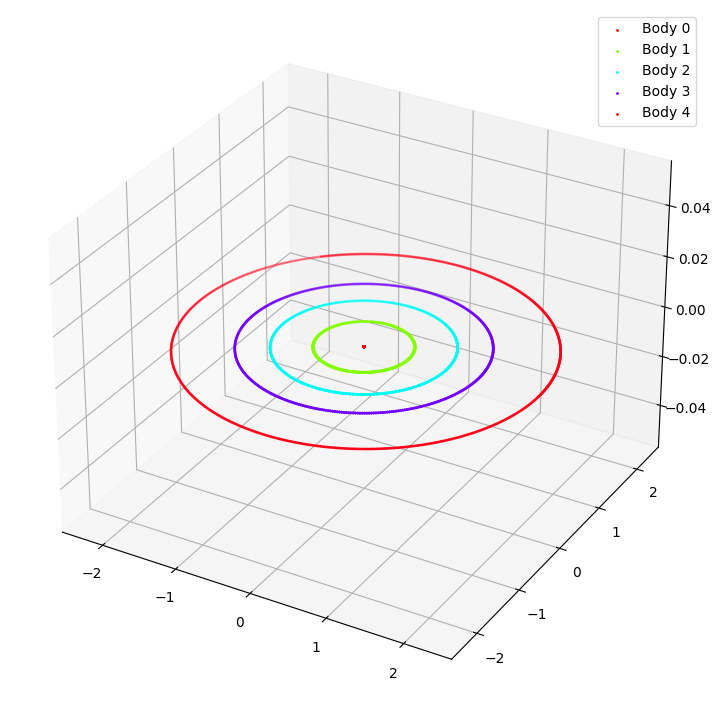

In [ ]:
simulation_(num_bodies = 4, seed = 17, dt = 86400, duration = 8, method = "AB", plot = "S", make_gif = False, test_case = "solar_system")

# **##############################**